In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from automouse_model import automouseTKV_model_2 

In [3]:
# figure out difference that needs to be made up in rows/columns
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

#after calculating the padding, add in the padding to rows and columns to meet new expected size
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [4]:
raw_path = r'C:\Users\UAB\data\KU'
new_path = r'C:\Users\UAB\data\AllNPY'
final_path = r'C:\Users\UAB\data\512_AllNII'
new_size = 512

In [5]:
patient_folders = []
pt_fnames = []

import os
for root, dirs, files in os.walk(os.path.normpath(raw_path), topdown=True):
    for name in files:
        #print(os.path.join(root, name))
        pt_fnames.append(os.path.join(root, name))
print('\nPatient Folders have been identified\n')
#sort through and get only the files with ROI in them
#this eliminates the tiff and 3D files 
#%%
ROI_list = []
for j in range(len(pt_fnames)):
    ROI_name = 'ROI'
    filename = os.path.basename(pt_fnames[j])
    if ROI_name in filename:
        ROI_list.append(pt_fnames[j])
print('\nFilenames have been found and added\n')


Patient Folders have been identified


Filenames have been found and added



In [ ]:
print('Converting', str(len(ROI_list)), 'files')
for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
    orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
    print(orig_fname)
    #extract information from the filename
    num_slice = int(orig_fname[-2:])
    #print(num_slice)
    if num_slice < 50:
        #print('over 99')
        num_slice = int(orig_fname[-3:])
        num_width = int((orig_fname[-8:-4]))
        #print(num_width)
        num_height = int((orig_fname[-12:-8]))
        #print(num_height)
    else:
        #print('less than 99')
        num_width = int((orig_fname[-7:-3]))
        #print(num_width)
        num_height = int((orig_fname[-11:-7]))
        #print(num_height)
    pt_numb =(orig_fname[0:6])
    yr_numb = (orig_fname[8])
    if 'Cyst' in orig_fname:
        img_type = 'C'
    elif 'Kidney' in orig_fname:
        img_type = 'M_K'
    elif 'Image' in orig_fname:
        img_type = 'M'
    if 'Right' in orig_fname:
        side = 'R'
    elif 'Left' in orig_fname:
        side = 'L'
    call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
    resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
    transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
    with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
         data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
         for j in range(num_slice):
             orig_slice = data[j]
             re_slice = Image.fromarray(orig_slice)
             resized[j] = resize_with_padding(re_slice, (new_size, new_size))
         for i in range(resized.shape[0]):
             old_slice = resized[i,:,:]
             transposed[:,:,i] = old_slice
             
             # now we need to rename this resized array and save it as a .npy
    #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
    new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
    file_name = "%s" %new_fname # add our extension
    np.save(os.path.join(new_path, file_name), transposed) # save in the new file folder
    converted_array = np.array(transposed, dtype=np.float32)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))


print("complete --- nice job")

In [17]:
path = r'C:\Users\UAB\data\512_AllNII\\'
cyst_names=[]
for root, dirs, files in os.walk(os.path.normpath(path), topdown=True):
    for name in files:
        #print(os.path.join(root, name))
        cyst_names.append(os.path.join(root, name))

C_list = []
for j in range(len(cyst_names)):
    C_name = '_C'
    filename = os.path.basename(cyst_names[j])
    if C_name in filename:
        C_list.append(cyst_names[j])

cyst_path = r"C:\Users\UAB\data\512_Cyst"
#cyst_path = r"C:\Users\schmi\data\NPY Cyst"
for i in range(len(C_list)):
    shutil.move(C_list[i],cyst_path )

In [5]:
data_path = r'C:\Users\UAB\data\512_AllNII\\'
images = []
segmentations = []
for f in os.listdir(data_path):
  if '_K' in f:
    continue
  else:
    images.append(f)
    segmentations.append(f.replace('.nii', '_K.nii'))

print(images[0], segmentations[0])
images = np.array(images)
segmentations = np.array(segmentations)

indices = np.array(range(len(images))) # we will use this in the next step.


101934_1_96_L_M.nii 101934_1_96_L_M_K.nii


In [6]:
print(len(images))

246


In [7]:
images = np.array(images[0:80])
segmentations = np.array(segmentations[0:80])
indices = np.array(range(len(images)))

In [8]:
print(len(images))

80


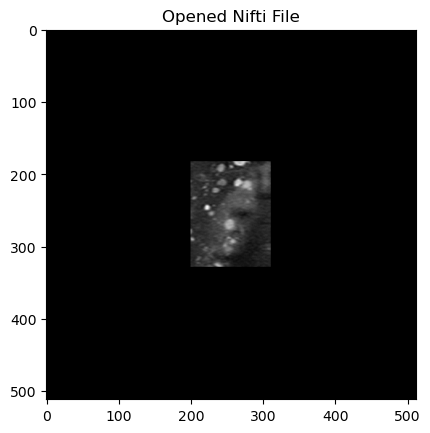

In [9]:
train, test = train_test_split(indices, test_size=0.25) # TODO: split indices into training and test partitions
path = (data_path+'\\'+images[train][0])
nifti_image = nib.load(path)
nifti_data = nifti_image.get_fdata()
nifti_slice = nifti_data[:,:,50]
plt.imshow(nifti_slice, cmap='gray')
plt.title('Opened Nifti File')
plt.show()

In [10]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')
    
def retrieve_images_and_segmentations(data_path, images, segmentations, size=(512,512)):
  x = []
  y = []
  for i in range(len(images)):
    seg = read_nifti_file(data_path+segmentations[i])
    img = read_nifti_file(data_path+images[i])
    assert img.shape == seg.shape
    seg = resize(seg,(size[0], size[1], seg.shape[-1]))
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(seg.shape[-1]):
      # ignore slices that don't have a segmentation
      if np.sum(seg[:,:,j]) == 0:
        continue
      x.append(img[:,:,j])
      y.append(seg[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]
  y = np.array(y)[:,:,:,np.newaxis]

  # randomly shuffle slices
  m = x.shape[0]
  order = np.random.permutation(m)

  return x[order], y[order]

def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

In [11]:
train, valid = train_test_split(train, test_size=0.25)
example_image = read_nifti_file(data_path+'\\'+images[train][0]) # TODO: read in the first image from the training partition
example_segmentation = read_nifti_file(data_path+'\\'+segmentations[train][0])  # TODO: read in the first segmentation from the training partition

print(example_image.shape, example_segmentation.shape)

(512, 512, 114) (512, 512, 114)


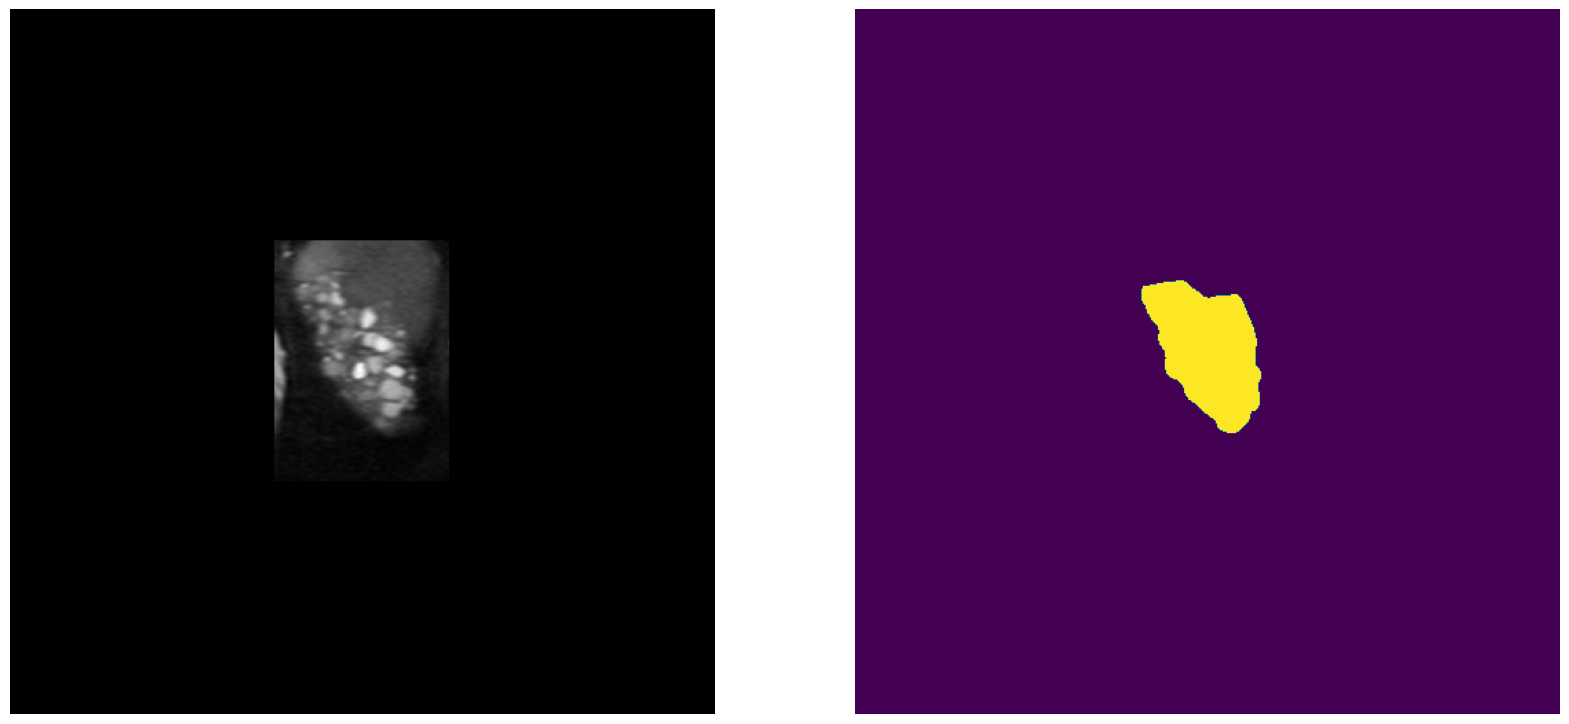

In [12]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(example_image[:,:,40], cmap='gray') # TODO: display the first slice from the image
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(example_segmentation[:,:,40])  # TODO: display the first slice from the segmentation
ax2.axis('off')
plt.show()

In [13]:
x_train, y_train = retrieve_images_and_segmentations(data_path, images[train], segmentations[train]) #TODO: get the matrices for the training partition
print(x_train.shape, y_train.shape)

(3163, 512, 512, 1) (3163, 512, 512, 1)


In [14]:
x_valid, y_valid = retrieve_images_and_segmentations(data_path, images[valid], segmentations[valid]) #TODO: get the matrices for the validation partition
print(x_valid.shape, y_valid.shape)

(1088, 512, 512, 1) (1088, 512, 512, 1)


In [15]:
x_test, y_test = retrieve_images_and_segmentations(data_path, images[test], segmentations[test]) #TODO: get the matrices for the test partition
print(x_test.shape, y_test.shape)

(1410, 512, 512, 1) (1410, 512, 512, 1)


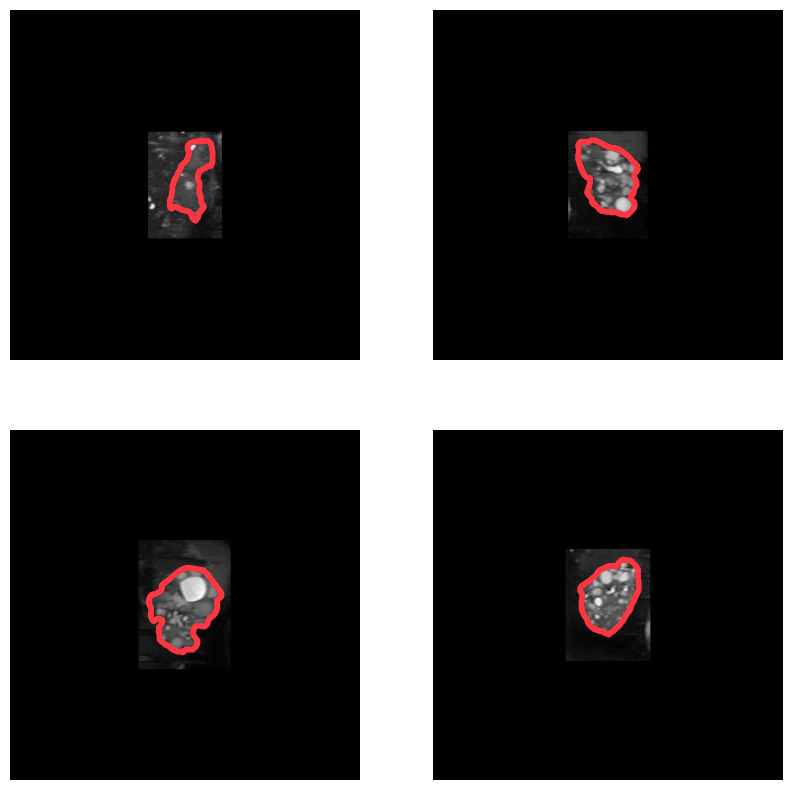

In [16]:
visualise_data(x_train, y_train)
plt.show()

In [17]:
model = custom_unet(input_shape=(512, 512, 1))

In [19]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [20]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

In [21]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=50)

Epoch 1/50
99/99 [==============================] - 57s 429ms/step - loss: -4.5526 - dice_coef: 1.7919 - val_loss: -5.5073 - val_dice_coef: 1.8609
Epoch 2/50
99/99 [==============================] - 37s 378ms/step - loss: -4.9888 - dice_coef: 1.8719 - val_loss: -5.6903 - val_dice_coef: 1.9014
Epoch 3/50
99/99 [==============================] - 38s 379ms/step - loss: -5.0554 - dice_coef: 1.8932 - val_loss: -5.7617 - val_dice_coef: 1.9228
Epoch 4/50
99/99 [==============================] - 37s 379ms/step - loss: -5.0853 - dice_coef: 1.9032 - val_loss: -5.7938 - val_dice_coef: 1.9328
Epoch 5/50
99/99 [==============================] - 38s 381ms/step - loss: -5.1237 - dice_coef: 1.9158 - val_loss: -5.8106 - val_dice_coef: 1.9380
Epoch 6/50
99/99 [==============================] - 38s 381ms/step - loss: -5.1473 - dice_coef: 1.9239 - val_loss: -5.8223 - val_dice_coef: 1.9416
Epoch 7/50
99/99 [==============================] - 37s 379ms/step - loss: -5.1706 - dice_coef: 1.9319 - val_loss: -5.

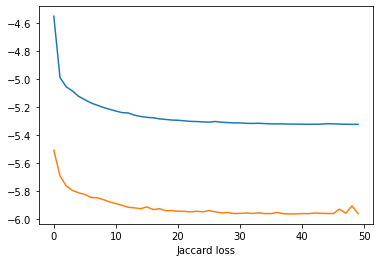

In [22]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

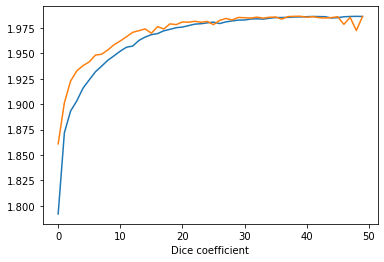

In [23]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [30]:
from keras.models import Sequential, load_model
model.save('my_model.h5')

In [33]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('my_model.h5')

In [34]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [35]:
y_pred_train = model.predict(x_train) #TODO: predict on the training set
y_pred_train = y_pred_train.astype('float') 

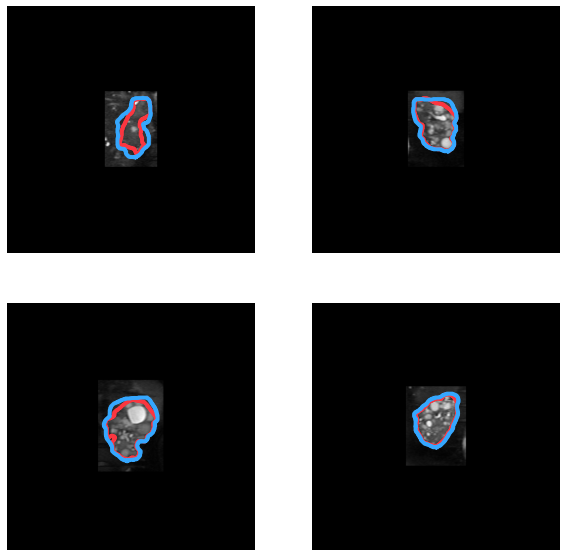

In [36]:
visualise_data_and_prediction(x_train, y_train, y_pred_train)

In [37]:
print('Dice:')
print(np.array(dice_coef(y_train, y_pred_train.astype('float'))))

Dice:


ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [38]:
y_pred_valid = model.predict(x_valid) #TODO: predict on the validation set
y_pred_valid = y_pred_valid.astype('float') # casting to type float to avoid ValueError later
#print('Dice:')
#print(np.array(dice_coef(y_valid, y_pred_valid.astype('float'))))

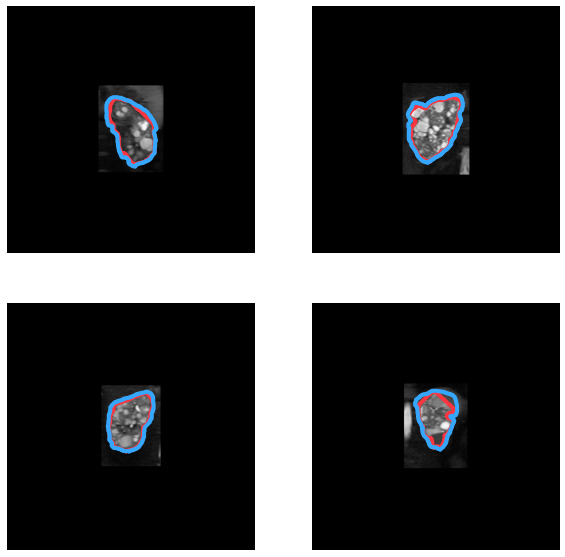

In [39]:
visualise_data_and_prediction(x_valid, y_valid, y_pred_valid)

In [40]:
image = nib.load(r"C:\Users\UAB\data\512_AllNII\101934_1_96_L_M.nii")

In [44]:
image_data = image.get_fdata()
data = np.asarray(image_data).astype(np.float32)

In [45]:
print(data.shape)

(512, 512, 96)


In [46]:
image_prediction = model.predict(data)

ValueError: in user code:

    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 512, 512, 1), found shape=(32, 512, 96)


In [ ]:
from automouse_model import automouseTKV_model_2
model = automouseTKV_model_2()
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])



In [ ]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=10)